In [90]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from dgfem2d import DGFEM2D

%matplotlib inline 

In [138]:
Lx, Ly, nx, ny  = 2.0, 2.0, 5, 3

def mask_fun(x):
    return np.sin(x/2)

x_range = np.linspace(0.0, Lx, nx, endpoint=True)

y_range = mask_fun(x_range)

bottom_shape = mask_fun(x_range)

x = np.tile(x_range, ny+1)

y = np.concatenate([i/ny*(Ly - bottom_shape) + bottom_shape for i in xrange(ny+1)])


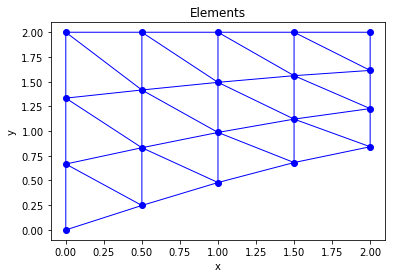

In [140]:
import matplotlib.tri as tri

triang = tri.Triangulation(x, y)

xmid = x[triang.triangles].mean(axis=1)

ymid = y[triang.triangles].mean(axis=1)

mask = np.where(ymid < mask_fun(xmid), 1, 0)

triang.set_mask(mask)

EtoV = triang.get_masked_triangles()

VX, VY = triang.x, triang.y

plt.triplot(triang, 'bo-', lw=1)

plt.xlabel('x')
plt.ylabel('y')

plt.title('Elements')


In [141]:
N = 10

fem = DGFEM2D(VX, VY, EtoV, N)

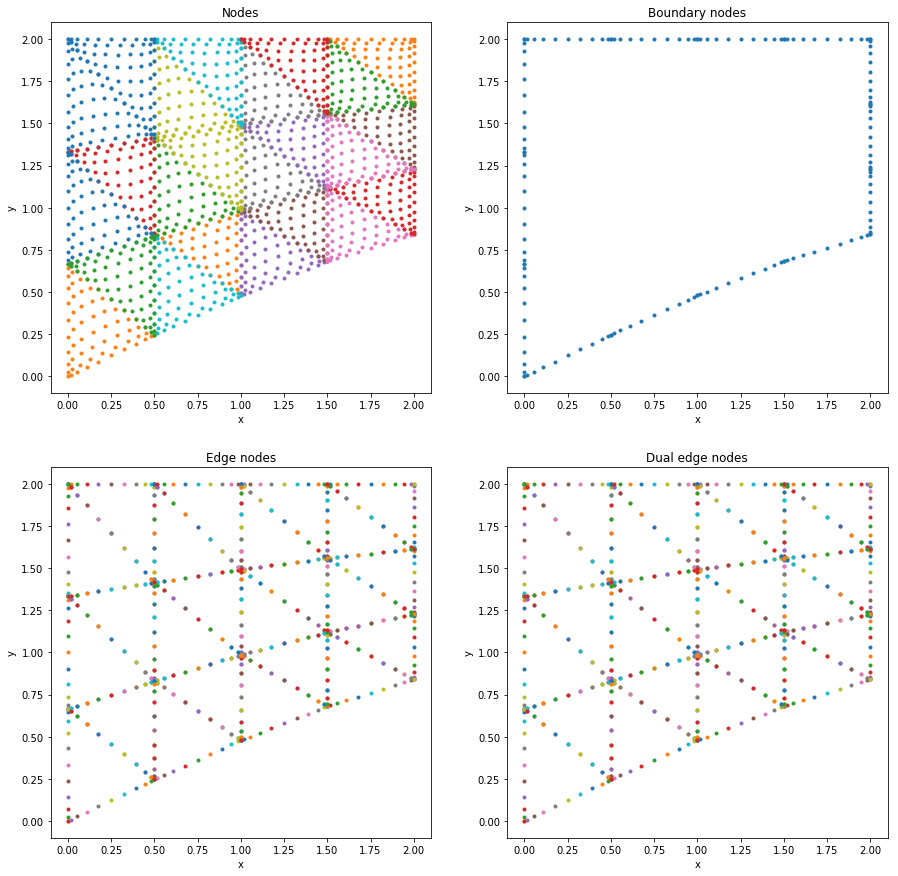

In [142]:
plt.figure(figsize=(15,15))

plt.subplot(2,2,1)
plt.plot(fem.X, fem.Y, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Nodes')

plt.subplot(2,2,2)
plt.plot(fem.X[fem.vmapB], fem.Y[fem.vmapB], '.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Boundary nodes')

plt.subplot(2,2,3)
plt.plot(fem.X[fem.vmapM], fem.Y[fem.vmapM], '.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Edge nodes')

plt.subplot(2,2,4)
plt.plot(fem.X[fem.vmapP], fem.Y[fem.vmapP], '.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Dual edge nodes')

plt.show()

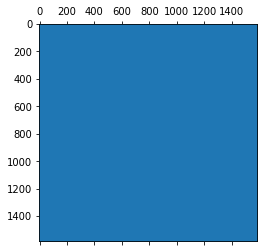

In [143]:
import numpy as np
def lap_operator(uu, sigma=0.1):
    u = uu.reshape(fem.X.shape, order='F')
    
    du = u[fem.vmapM] - u[fem.vmapP]
    du[fem.mapB] = 2*u[fem.vmapB]

    dudx, dudy = fem.grad(u)

    fluxxu = fem.nx*du/2.0
    fluxyu = fem.ny*du/2.0

    qx = dudx - np.matmul(fem.lift, fem.Fscale*fluxxu)
    qy = dudy - np.matmul(fem.lift, fem.Fscale*fluxyu)

    dqx = qx[fem.vmapM] - qx[fem.vmapP]
    dqy = qy[fem.vmapM] - qy[fem.vmapP]

    #fluxq = (fem.nx*dqx + fem.ny*dqy + sigma*du)/2.0
    fluxq = fem.nx*(qx[fem.vmapM] - 0.5*(dudx[fem.vmapM]+dudx[fem.vmapP])) +\
            fem.ny*(qy[fem.vmapM] - 0.5*(dudy[fem.vmapM]+dudy[fem.vmapP])) + sigma*du
    
    divq = fem.div(qx, qy)

    lapu = divq - np.matmul(fem.lift, fem.Fscale*fluxq)

    return lapu.ravel(order='F')

import scipy.sparse.linalg as sparse
from scipy.sparse import csr_matrix

lap_op = sparse.LinearOperator((fem.K*fem.Np, fem.K*fem.Np), matvec=lap_operator)

lap_mat = lap_op.matmat(np.eye(fem.K*fem.Np))

plt.spy(csr_matrix(lap_mat), precision=0.01, markersize=1)

plt.show()



In [144]:
nev = 10

vals_all, vecs_all = np.linalg.eig(lap_mat)

idx = np.argsort(np.abs(vals_all))

vals, vecs = vals_all[idx[:nev]], vecs_all[:,idx[:nev]]

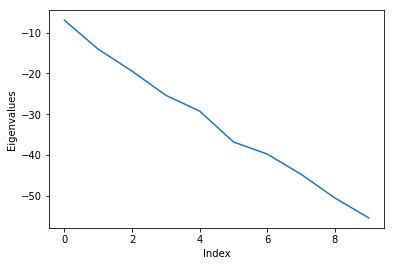

In [145]:

plt.figure()
plt.plot(np.real(vals))
plt.xlabel('Index')
plt.ylabel('Eigenvalues')
plt.show()


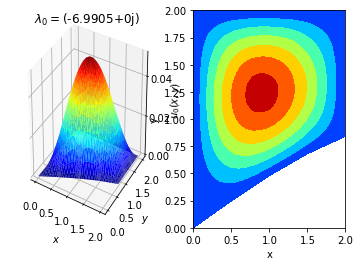

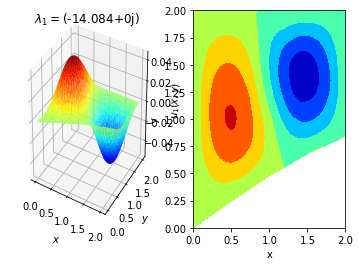

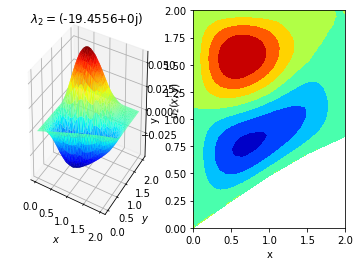

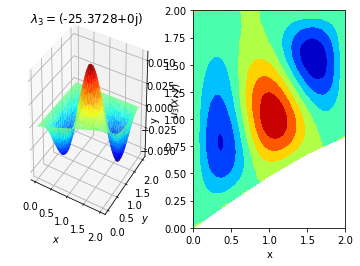

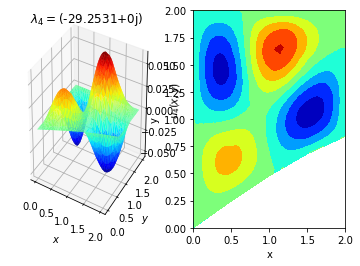

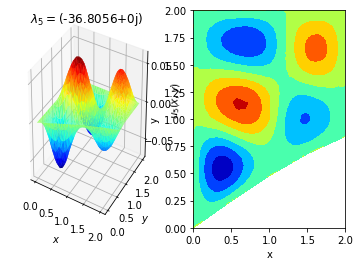

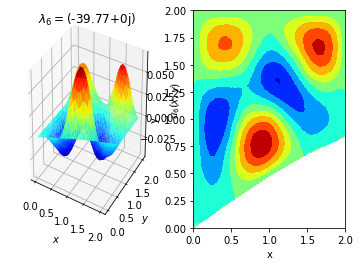

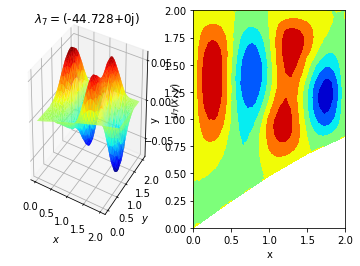

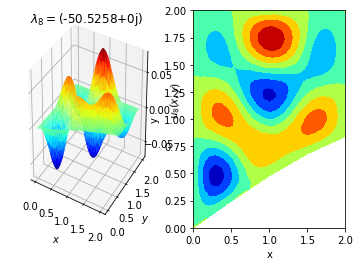

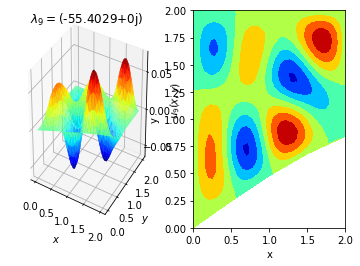

In [147]:
xx, yy = fem.X.ravel(), fem.Y.ravel()

fem_tri = tri.Triangulation(xx, yy)

xx, yy = fem.X.ravel(order='F'), fem.Y.ravel(order='F')

fem_tri = tri.Triangulation(xx, yy)

fem_xmid = xx[fem_tri.triangles].mean(axis=1)
fem_ymid = yy[fem_tri.triangles].mean(axis=1)

fem_mask = np.where(fem_ymid < mask_fun(fem_xmid), 1, 0)

fem_tri.set_mask(fem_mask)

for i in range(nev):
    fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    surf = ax.plot_trisurf(fem_tri, np.real(vecs[:,i]), cmap=cm.jet, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$u_' + str(i) + '(x,y)$')
    ax.set_title('$\lambda_' + str(i) + '=$' + str(np.round(vals[i],4)))
    
    plt.subplot(1,2,2)
    plt.tricontourf(fem_tri, np.real(vecs[:,i]), cmap=cm.jet, linewidth=0)
    plt.xlabel('x')
    plt.ylabel('y')
        
plt.show()